### 1. Reading datasets

In this analysis, we will train a machine learning model to predict star ratings based on review comments. We use existing natural language processing tools and libraries to perform text pre-processing and sentiment analysis. Here, we have a dataset of hotel reviews that consist of 30,000 rows of customer reviews along with their ratings. The goal of this project is to determine which machine learning model works the best to predict the `overall` score by comparing the performance of multiple combinations of text pre-processing techniques and machine learning models. We will also perform exploratory data analysis (EDA) before the model training to gain a better understanding of the data and to ensure that each necessary process is taken to achieve efficient and high perfoming model.

To begin, we will load the dataset stored in a JSON file. The data is stored in a format where each line is a separate JSON object, indicated by the file is not enclosed in an array (Pandas 2024).

In [ ]:
# Load data
import pandas as pd
df = pd.read_json('./data/random_30000_hotel_reviews.JSON', lines=True)
df.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile
0,"{'service': 1.0, 'cleanliness': 2.0, 'overall'...",“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False
1,"{'cleanliness': 1.0, 'sleep_quality': 1.0, 'ov...",“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False
3,"{'service': 3.0, 'cleanliness': 2.0, 'overall'...",“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False
4,{'overall': 1.0},“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False


In [2]:
# Supress warnings to remove less necessary warnings
import warnings
warnings.filterwarnings("ignore")

Next, we want to check the dataset size and concatenate the `title` and `text` columns into one column, which will later used as the text input for sentiment analysis. We combine these two columns because, if we take a quick look, the `title` column contain a short summary of the customer review, which really useful in determining the sentiment of each reviews.

In [3]:
# Check the initial data dimension
print("Dataframe size: ", df.shape[0], "rows x ", df.shape[1], "columns")

# Concat text and title
df['concat_title_text'] = df['title'] + " " + df['text']

# Preview the result
df[['title', 'text', 'concat_title_text']][:5]

Dataframe size:  30000 rows x  10 columns


,title,text,concat_title_text
0,“Horrible experience”,First of all we got there and they didn't have...,“Horrible experience” First of all we got ther...
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,“Stay Away” Found Racist graffiti in the room....
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,“Great location and service” Close to Union Sq...
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,“I will never go back here again!” I had a bad...
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...",“Ripped off our VISA card after departure” Aft...


As mentioned, the `title` column contain a good summary  of customer review, making it easier to identify the sentiment. Notice that "horrible" and "never" are a strong keywords for negative sentiment, while "great" is a strong keywords for positive sentiment. Thus, we will use the `concat_title_text` to predict the `overall` rating in the analysis process later.

Following this, we also obtain that the dataframe consist of 30,000 rows. We will split this into 3 dataframe that is `train_df`, `dev_df`, and `test_df`. We will use the `dev_df` for development to explore which model performs best, while `train_df` and `test_df` will be used for training and test with the final model.

In [4]:
# Split data into training, development, and test data set
# Training data set consist of the first 10000 lines
train_df = df[:10000]
# Development data set consist of the next 10000 lines
dev_df = df[10000:20000].reset_index(drop=True)
# Test data set consist of the remaining 10000 lines
test_df = df[20000:].reset_index(drop=True)

The development will start with removing any non-alphanumeric characters from our string reviews so that they only consist of letters and numbers. This is useful to eliminate unecessary character that will become noise to our model (GeeksfoGeeks 2025). Following this, we will tokenize the entire review comments in the development dataset to obtain the collection of vocabulary that will be used to further exploration and analysis.

In [5]:
import re
import nltk
from nltk.tokenize import word_tokenize

# Function to remove unecessary characters from text 
def regex_text(text):
    
    # Remove any non-alphanumeric characters by keeping only letters, numbers, and spaces using regex
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text) + ' '

    return text

# Function to extract the tokenized corpus from specific columns in a dataframe 
def tokenize_column(df, col, lower_case=False):
    sentiment_text = ' '.join(df[col])

    # Tokenize the text
    if lower_case==True:
        tokens = word_tokenize(sentiment_text.lower())
    else:
        tokens = word_tokenize(sentiment_text)

    return tokens

In [6]:
# Apply the regex function to the concatenated column
dev_df["regexed_text"] = dev_df["concat_title_text"].apply(regex_text)

# Extract tokenized corpus from the concatenated column
tokenized_corpus = tokenize_column(dev_df,'regexed_text')

# Preview the tokenized corpus result
tokenized_corpus[:10]


['Nice',
 'hotel',
 'great',
 'location',
 'This',
 'was',
 'a',
 'nice',
 'hotel',
 'for']

### 2. Exploratory Data Analysis (EDA)

In this section, we will explore the dataset to understand the distribution of each features value and identify any potential issues. To begin, we notice that some columns contains dictionary values. We will separate each dictionary key into new column to make it easier to iterate in the following process.

In [7]:
# Function to expand the 'ratings' and 'author' values into new columns for each key
def expand_columns(df):
    for row in range(len(df)):
        for col in ['ratings', 'author']:
            for k, v in df[col][row].items():
                df.loc[row, k] = v
    
    return df

# Expand the dictionary values in 'ratings' and 'author'
dev_df = expand_columns(dev_df)

# Preview the result
dev_df.head(5)

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,...,value,location,sleep_quality,rooms,username,num_cities,num_reviews,num_type_reviews,check_in_front_desk,business_service_(e_g_internet_access)
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Nice hotel - great location”,This was a nice hotel for the price I got at t...,"{'username': 'metalchicRichmond', 'num_cities'...",July 2011,84107,0,2012-05-04,AF5EE85EDBDA6D76318AB42AC8F3A780,False,...,4.0,Richmond,5.0,4.0,metalchicRichmond,5.0,13.0,6.0,NaN,NaN
1,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Perfect location and the room was generous in...,I stayed in this hotel in December of 2010 and...,"{'username': 'Noelle20', 'num_reviews': 1, 'id...",February 2011,93464,0,2011-02-15,9983BEFCFA0B7CD9AE4587D6A961C907,False,...,4.0,"Washington DC, District of Columbia",4.0,4.0,Noelle20,NaN,1.0,NaN,NaN,NaN
2,"{'service': 1.0, 'cleanliness': 4.0, 'overall'...","“Rude staff, extra charges, overall unimpressive”",We traveled here with a big group for a weddin...,"{'username': 'amanduhcorazon', 'num_cities': 4...",September 2011,109008,25,2011-09-23,9C3CA4390CAD3EF7F823000AFBC8261A,False,...,2.0,"Glenwood Springs, Colorado",4.0,3.0,amanduhcorazon,4.0,17.0,NaN,NaN,NaN
3,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...","“Great location, would stay here again”",Stayed here for 3 nights. Our room was a large...,"{'username': 'Peter G', 'num_cities': 6, 'num_...",November 2011,223019,7,2011-11-14,952763440840718D6F3C0633D583D119,False,...,3.0,"Westport, Ireland",4.0,4.0,Peter G,6.0,8.0,4.0,NaN,NaN
4,"{'service': 3.0, 'cleanliness': 4.0, 'overall'...",“Disappointed in Chicago”,I stayed at the Allerton Hotel on the night of...,"{'username': 'redinked', 'num_cities': 12, 'nu...",August 2012,90973,8,2012-08-16,3F38077A3FD948C54036D2D446E03E07,False,...,3.0,"Indianapolis, Indiana",4.0,2.0,redinked,12.0,24.0,14.0,NaN,NaN


Here, we will also check for null values in the dataframe and found that the key features that will be used for analysis (`title`, `text`, and  `overall`) do not have any missing values. Thus, no further action is required to handle missing values. However, we will explore the other features to determine whether they will be useful for our sentiment analysis model.

In [8]:
# Checking for null in the dataframe
dev_df.isna().sum()

ratings                                      0
title                                        0
text                                         0
author                                       0
date_stayed                                398
offering_id                                  0
num_helpful_votes                            0
date                                         0
id                                           0
via_mobile                                   0
concat_title_text                            0
regexed_text                                 0
service                                   1032
cleanliness                               1046
overall                                      0
value                                     1046
location                                     0
sleep_quality                             4116
rooms                                     1682
username                                     0
num_cities                                2632
num_reviews  

Next, we will perform visualisation focusing on the `overall` rating and review comments to determine whether any pre-processing steps are needed to improve our analysis.

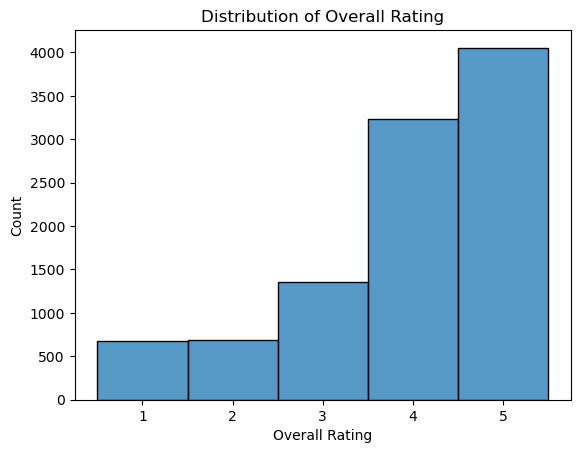

In [9]:
# Plot the distribution of 'overall' rating

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(dev_df['overall'], bins=5, discrete=True)
plt.title('Distribution of Overall Rating')
plt.xlabel('Overall Rating')
plt.show()

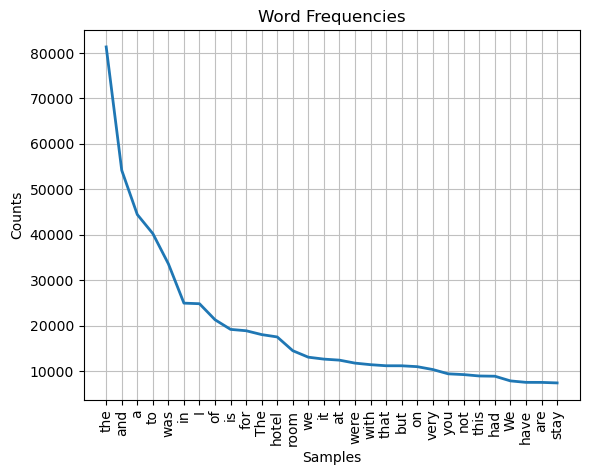

<Axes: title={'center': 'Word Frequencies'}, xlabel='Samples', ylabel='Counts'>

In [10]:
# Plot word frequencies from the tokenized corpus

from nltk.probability import FreqDist

# Count the word frequency using FreqDist function
fdist = FreqDist(tokenized_corpus)

plt.title('Word Frequencies')
fdist.plot(30, cumulative=False)

From the distribution plot, we found that our dataset is imbalanced where, as the good ratings (4 and 5) have more records compared to the bad ratings. This will be taken into account as it is relevant to the modelling process. Also, from the word frequency plot, we could not obtain any meaningful insights, as the common words did not represent any sentiment. Notice that "the" and "The" are separated into two categories, which creates noise to show insights in the visualisation.

Thus, we will remove the stop words and apply lowercasing to the tokens to make the frequency plot more useful. We will also categorise ratings greater than or equal to 3 into "positive" and rating less than 3 into "negative" to analyse the most common in each category.

In [11]:
# Define function to perform text preprocessing and categorise ratings

from nltk.corpus import stopwords
import spacy

stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 5_000_000  # Increase the maximum allowed text length for lemmatisation

# Function to preprocess text, optionally remove stopwords, apply lemmatisation and lowercasing (Accept text or tokenized input)
def text_preprocessing(text, remove_stop_word=False, lemmatisation=False, lower_case=False, input_tokens=False, return_tokens=False):

    # Lowercasing
    if lower_case:
        text = text.lower()

    # Tokenize the text
    if not input_tokens:
        tokens = word_tokenize(text)
    else:
        tokens = text
        
    # Remove stopwords
    if remove_stop_word:
        tokens = [word for word in tokens if word not in stop_words]
        text = " ".join(tokens)

    # Lemmatisation
    if lemmatisation:
        doc = nlp(text) 
        tokens = [token.lemma_ for token in doc]
    
    # Return the cleaned text or tokens
    if return_tokens:
        return tokens
    else:
        return " ".join(tokens)

# Function to categorise review and count word frequency for each category
def get_word_frequencies(df, sentiment):

    # Categorise into 'positive' or 'negative' sentiment
    if sentiment == 'positive':
        sentiment_df = df[df['overall'] >= 3].copy().reset_index(drop=True)
        

    elif sentiment == 'negative':
        sentiment_df = df[df['overall'] < 3].copy().reset_index(drop=True)

    # Preprocess and tokenise text
    sentiment_df['regexed_text'] = sentiment_df['concat_title_text'].apply(regex_text)
    tokens = tokenize_column(sentiment_df, 'regexed_text', lower_case=True)
    preprocessed_tokens = text_preprocessing(tokens, remove_stop_word=True, input_tokens=True, return_tokens=True)

    # Count the word frequency
    fdist = FreqDist(preprocessed_tokens)
        
    return fdist

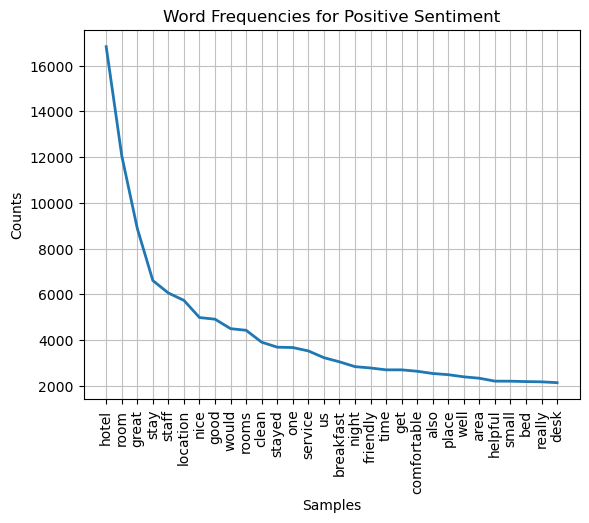

<Axes: title={'center': 'Word Frequencies for Positive Sentiment'}, xlabel='Samples', ylabel='Counts'>

In [12]:
# Plot word frequencies for 'positive' sentiment

plt.title('Word Frequencies for Positive Sentiment')
get_word_frequencies(dev_df,'positive').plot(30, cumulative=False)

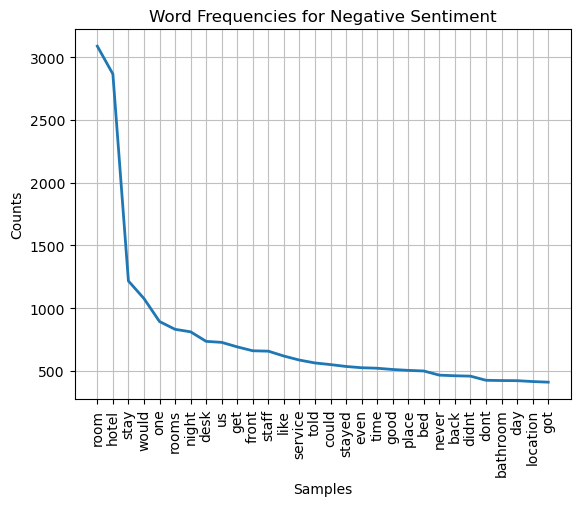

<Axes: title={'center': 'Word Frequencies for Negative Sentiment'}, xlabel='Samples', ylabel='Counts'>

In [13]:
# Plot word frequencies for 'negative' sentiment

plt.title('Word Frequencies for Negative Sentiment')
get_word_frequencies(dev_df,'negative').plot(30, cumulative=False)

From each plot, we found that the common words can better express each sentiment. In the positive sentiment plot, we found the common words such as "great", "nice" and "good". While in the negative sentiment, we found "didnt" and "dont" as the common words. However, we also found "good" in the negative sentiment that does not align with our expectation.

Regardless, we found that implementing preprocess to the text improve our ability to better understand each sentiment and therefore necessary to be applied for the analysis later. 

Moving forward, we will explore the distribution of the review comments length to determine whether the dataset contain more short or long reviews.

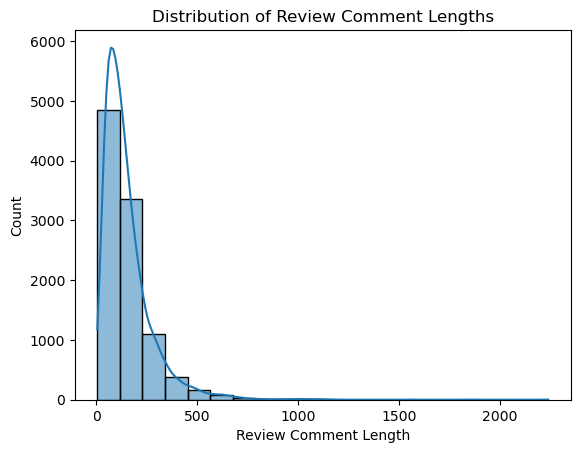

In [14]:
# Plot the distribution of review comments lengths

dev_df['text_length'] = dev_df['text'].apply(lambda x: len(x.split()))
sns.histplot(dev_df['text_length'], bins=20, kde=True)
plt.title('Distribution of Review Comment Lengths')
plt.xlabel('Review Comment Length')
plt.show()

We found that the majority of the text lengths are short to medium, with less than 500 characters. This shows that users rarely leave lengthy reviews. Therefore, machine learning algorithms will work well with our data, and it won't be necessary to use deep learning models, as they are typically beneficial for longer and more complex texts.

Next, we also want to see whether there are other features that could be used to improve the sentiment analysis besides the `concat_title_text` column. Here, we want to explore the `location` column to check whether it has a correlation and significantly contributes to predict the rating in the `overall` column. After reviewing the data, we found that the values in that column are inconsistent. Therefore, we implement some simple preprocessing to clean the values and make them more general.

In [15]:
# Function to preprocess 'location' column

def preprocess_location(df):
    for i in range(len(df)):
        loc = df.loc[i, "location"]

        # Lowercasing and extract the city name only
        loc = loc.lower().split(',')[0]
     
        # Save the preprocessed location string into a new column
        df.loc[i, "preprocessed_location"] = loc
    
    return df

# Preprocess 'location' string and show the preview of the result
preprocess_location(dev_df)[["location", "preprocessed_location"]].head()


,location,preprocessed_location
0,Richmond,richmond
1,"Washington DC, District of Columbia",washington dc
2,"Glenwood Springs, Colorado",glenwood springs
3,"Westport, Ireland",westport
4,"Indianapolis, Indiana",indianapolis


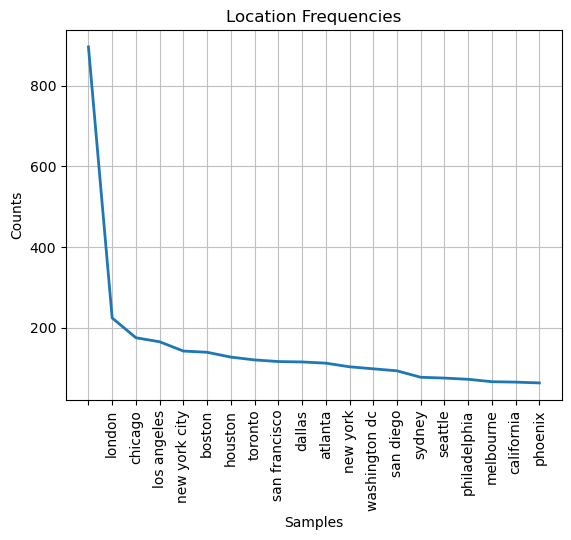

In [16]:
# Plot the "location" frequencies

location_count = FreqDist(dev_df['preprocessed_location'])

plt.title('Location Frequencies')
location_count.plot(20, cumulative=False)
plt.show()

In [17]:
# Compare unique location counts before and after preprocessing

print('Count of location before preprocessing:', len(dev_df['location'].unique()))
print('Count of location after preprocessing:', len(dev_df['preprocessed_location'].unique()))

Count of location before preprocessing: 4016
Count of location after preprocessing: 2736


We used the Chi-Square test to examine the independence of two attributes. The two features are assumed to be independent and a high value of Chi-Square indicates that the hypothesis of independence is incorrect (Zainuddin & Ali 2014, p. 334). Thus, with this statistics, we can identify whether certain features are relevant to the target value, and we will implement this to the `location` column.

In [18]:
# Function to perform Chi-Square test for feature selection

import pandas as pd
import scipy.stats as stats

def chi2_test(df, col, target_col):

    # Create contingency table
    contingency_table = pd.crosstab(df[col], df[target_col])

    # Apply Chi-Square Test
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

    alpha = 0.05
    print('Column: ', col)
    print('Chi-Square test')

    if p > alpha:
        print('Independent of each other (fail to reject H0)')
    else:
        print('Dependent on each other (reject H0)')
    print(f"stat = {chi2}, p = {p} \n")

In [19]:
# Implement the Chi-Square test

chi2_test(dev_df, 'preprocessed_location', 'overall')

Column:  preprocessed_location
Chi-Square test
Independent of each other (fail to reject H0)
stat = 10560.87308327473, p = 0.9951840852172777 



From the statistics result, we found that the `location` column is independent to the `overall` column, which indicates that it does not significantly contributes to the rating number. Thus, we will only use the concatenated title and text as our feature to predict the `overall` value.

We also explore the N-grams, which are sequences of words, to identify the most common phrases in the dataset. Below, we will visualise the common phrases with 2-grams and 3-grams.

In [21]:
# Define function to generate n-grams and visualise the most common phrases.

from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt

# Function to generate n-grams
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

# Function to count the common n-grams
def ngrams_count(n):

    # Tokenize text
    dev_tokens = tokenize_column(dev_df,'regexed_text', lower_case = True)

    # Preprocess tokens
    preprocessed_tokens = text_preprocessing(dev_tokens, remove_stop_word=True, input_tokens=True, return_tokens=True)

    # Generate n-grams
    ngrams_list = generate_ngrams(preprocessed_tokens, n)

    # Count the occurrences of each n-gram
    ngrams_count = Counter(ngrams_list)

    return ngrams_count


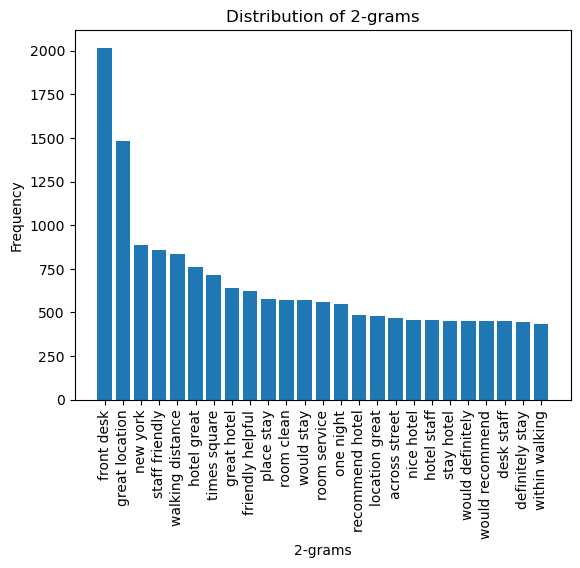

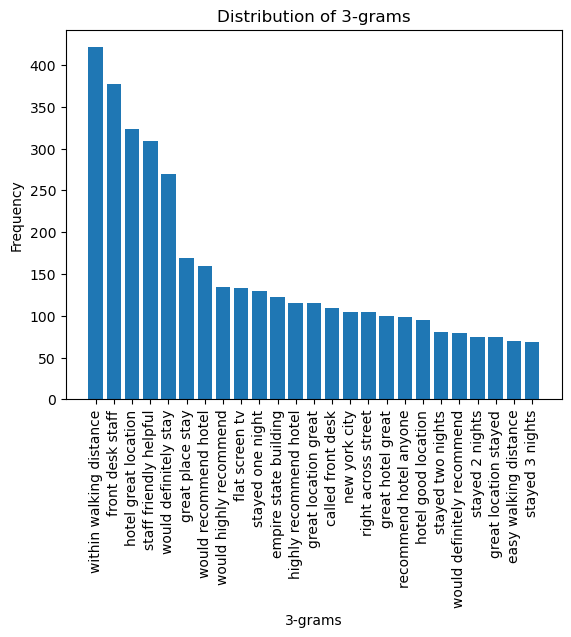

In [22]:
# Plot n-grams frequencies

bigrams = ngrams_count(2).most_common(25)
trigrams = ngrams_count(3).most_common(25)

labels_bigrams, values_bigrams = zip(*bigrams)
indexes_bigrams = range(len(labels_bigrams))

labels_trigrams, values_trigrams = zip(*trigrams)
indexes_trigrams = range(len(labels_trigrams))

# Plot for 2-grams
plt.bar(indexes_bigrams, values_bigrams)
plt.xlabel('2-grams')
plt.ylabel('Frequency')
plt.xticks(indexes_bigrams, labels_bigrams, rotation='vertical')
plt.title(f'Distribution of 2-grams')
plt.show()

# Plot for 3-grams
plt.bar(indexes_trigrams, values_trigrams)
plt.xlabel('3-grams')
plt.ylabel('Frequency')
plt.xticks(indexes_trigrams, labels_trigrams, rotation='vertical')
plt.title(f'Distribution of 3-grams')
plt.show()

From the plot, we found that each n-gram provides significant insight into sentiment. In the bigrams, we observed more sentiment-related expressions compared to the trigrams, such as "great location", "great hotel", "friendly helpful", and "definitely stay". However, both n-grams share common ground, where they mention "front desk". "staff", and "hotel" frequently, which indicates that these aspects are important to customers.

### 3. Preprocessing

In this section, we will define functions to preprocess the data prior to model training. From the EDA section, we found that our data is imbalanced, with ratings of 4 and 5 dominating the dataset. To address this, we will implement **upsampling** to balance the dataset.

We choose upsampling because our model training uses 10,000 rows, which is considered as a medium sized dataset, making it less ideal to remove data that would result in information loss. We will perform the upsampling using **random duplication**, as it is easier to implement and more suitable for our dataset size. Another alternative is SMOTE, however our dataset is not large enough for this technique to provide significant improvement to the model. SMOTE requires a larget dataset to generate synthetic samples effectively (Kraiem, Sánchez-Hernández & Moreno-García 2021, p. 14). 

In the modeling process, we will perform the upsampling after vectorizing our text data into tokens. This is important because we do not want the vectorized weights to be affected by the upsampling, which could increase the weight due to the data duplication (Mujahid et al. 2024, p. 11). Because of this, it is also more suitable to use random sampling, as SMOTE is less effective in handling imbalanced datasets with high-dimensional data compared to random oversampling (Blagus & Lusa 2013, p. 2). Therefore, we choose random duplication as it is simpler, more efficient, and better suited for our dataset.

Here, we will also define a function to implement vectorization so that we can test the upsampling function. The vectorization will be implemented using **TF-IDF**, as it considered a more advanced and efficient method. As our dataset is medium size, TF-IDF offers better interpretability and performance in capturing the content and information of text compared to Word2Vec (Zhan 2025, p. 6). Its ability to acount for the significance of terms and their contextual relevance helps minimize noise and enhance the quality of data extracted from the text (Zhan 2025, p. 2).

To start, we will split the development dataset into 80% training data and 20% test data as a demonstration to evaluate the performance of the functions defined in this part.

In [23]:
# Demo split into train and test dataset
# Split the dev_df into 80% training dataset and 20% test dataset to test the algorithm performance

train_dev_df = dev_df[:8000]
test_dev_df = dev_df[8000:]

X_train_dev_df, y_train_dev_df = train_dev_df['regexed_text'], train_dev_df['overall']
X_test_dev_df, y_test_dev_df = test_dev_df['regexed_text'], test_dev_df['overall']

In [24]:
# Feature Extraction using TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

def feature_extraction(X_train, X_test, ngrams=(0,0)):
    if ngrams != (0,0):
        vectorizer = TfidfVectorizer(ngram_range=ngrams)
    else: 
        vectorizer = TfidfVectorizer()

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    features = vectorizer.get_feature_names_out()

    return X_train, X_test, features


We will examine the performance of using n-grams in our modelling process, which is why we included the option for n-grams in the `feature_extraction` function. As mentioned in the previous section, we found that n-grams can extract sentiment-related expressions that could potentially improve our model performance.

In [25]:
# Demo to show the functionality of TF-IDF
# Unigrams
X_train_tfidf_unigrams, X_test_tfidf_unigrams, features_unigrams = feature_extraction(X_train_dev_df, X_test_dev_df)
print("Unigrams features preview:", features_unigrams[10000:10005])

# Bigrams
X_train_tfidf_bigrams, X_test_tfidf_bigrams, features_bigrams = feature_extraction(X_train_dev_df, X_test_dev_df, (2,2))
print("Bigrams features preview:", features_bigrams[10000:10005])

Unigrams features preview: ['distancegreat' 'distancehop' 'distancei' 'distanceif' 'distancein']
Bigrams features preview: ['again overall' 'again overpriced' 'again paid' 'again parking'
 'again part']


In [26]:
# Oversampling with random duplicating minority classes

import numpy as np
from sklearn.utils import shuffle

def upsampling(X_sparse, y, print_result=False):
    np.random.seed(42)
    
    classes = y.unique()
    majority_size = y.value_counts().max()

    selected_indices = []
    
    for rating in classes:
        class_size = y.value_counts()[rating]

        class_filter = (y == rating).values
        class_index = np.where(class_filter)[0]

        if class_size != majority_size:
            num_samples = majority_size - class_size
            indices_upsampling = np.random.choice(class_index, size=num_samples, replace=True)
            class_index = np.concatenate([class_index, indices_upsampling])
        
        selected_indices.extend(class_index)

    # Collect the upsampling indices
    selected_indices = np.array(selected_indices)
    X_upsampling = X_sparse[selected_indices]
    y_upsampling =y.iloc[selected_indices].reset_index(drop=True)

    X_shuffled, y_shuffled = shuffle(X_upsampling, y_upsampling, random_state=42)

    if print_result:
        print("Original dataset shape:\n", y.value_counts(), "\n")
        print("Upsampling dataset shape:\n", y_upsampling.value_counts())

    return X_shuffled, y_shuffled

In [27]:
# Demo to show the functionality of random oversampling
X_train_upsampling, y_train_upsampling = upsampling(X_train_tfidf_unigrams, y_train_dev_df, True)

Original dataset shape:
 overall
5.0    3289
4.0    2571
3.0    1074
2.0     543
1.0     523
Name: count, dtype: int64 

Upsampling dataset shape:
 overall
4.0    3289
2.0    3289
3.0    3289
5.0    3289
1.0    3289
Name: count, dtype: int64


### 4. Selecting supervised method for sentiment classification

We will examine the performance of supervised methods using **Multinomial Naive Bayes (MNB)** and **Random Forest (RF)**. MNB is one of the simplest probabilistic classifier model that is computationally very efficient and easy to implement. It utilized Bayes theorem to classify features that assumes all features to be independent to efficiently compute the conditional probabilities (Polpinij & Luaphol 2021, p. 170). 

On the other hand, RF is an ensemble of several decision trees that make the prediction to be more accurate than only using individual tree. This algorithm is versatile as it can handle high-dimensional data and can reduce overfitting by the randomness when building each tree (Polpinij & Luaphol 2021, p. 170).

Considering we use TF-IDF method, it produces high-dimensional and sparse data. Next, as we implementing oversampling we have to consider the potential of expose to overfitting during model training. However, MNB works well with high-dimensiontal data with its probabilistic nature allows it to remain stable during traning (Taniya 2018). RF also less sensitive to duplicated data from its process of averaging or combining the result of different decision tress that help to avoid overfitting (Taniya 2018).

We do not examine the performance of model training with Linear Regression (LR) as it is not suitable for classification tasks Support Vector Machine (SVM) and k-Nearest Neigbors (k-NN) are also not examinated as they have has higher computational complexity making them not suitable to large dataset and high-dimensional sparse TF-IDF features, as well as could be sensitive to duplicated data (Halder et al. 2024, p. 3). Lastly, Multilayer Perceptron (MLP) is not examined as it requires a larger dataset to be able to perform effectively.

The evaluation metrics used are **accuracy** and **F1-macro**. The F1-macro score compute the metrics independently for each class and then take the average. Thus, all classes, majority as well as minority, are weighted equally (Hinojosa-Lee, Braet & Springael, J 2024, p. 11). The dataset was imbalanced, however after oversampling, we obtained balanced dataset. Therefore, F1-macro can be utilized to better reflect the model ability in classfying minority ratings and its overall performance of clasfifying each class.

We also implemented the **10-fold cross validation** to evaluate the performance of each model and text preprocessing combination. The 10-fold cross validation procedure able to prevent overfitting by training and evaluating the model with different subsets of dataset (Polpinij & Luaphol 2021, p. 171).

In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

# Function to train a Multinomial Naive Bayes classifier 
def mnb_model_training(X_train, y_train, X_test, y_test, print_result=False):
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)

    # Predict with trained model
    y_pred_mnb = mnb.predict(X_test)
    
    # Evaluate the models on the test set
    if print_result:
        print("Multinomial Naive Bayes:")
        print("Accuracy:", accuracy_score(y_test, y_pred_mnb))
        print("F1 score:", f1_score(y_test, y_pred_mnb, average='micro'))
        print(classification_report(y_test, y_pred_mnb))

    return y_pred_mnb

# Function to train a Random Forest classifier
def rf_model_training(X_train, y_train, X_test, y_test, print_result=False):
    rf = RandomForestClassifier(n_estimators=10, random_state=42)
    rf.fit(X_train, y_train)

    # Predict with trained model
    y_pred_rf = rf.predict(X_test)
    
    # Evaluate the models on the test set
    if print_result:
        print("Multinomial Naive Bayes:")
        print("Accuracy:", accuracy_score(y_test, y_pred_rf))
        print("F1 score:", f1_score(y_test, y_pred_rf, average='macro'))
        print(classification_report(y_test, y_pred_rf))

    return y_pred_rf

# Cross Validation
def cross_val(X, y, model, ngrams=(0,0)):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    accuracy_scores = []
    f1_scores = []

    # Perform 10-Fold Cross-Validation
    for train_df, test_df in cv.split(X, y):

        # Split data into training and testing sets
        X_train, X_test = X[train_df], X[test_df]
        y_train, y_test = y.iloc[train_df], y.iloc[test_df]

        # TF-IDF
        X_train_tfidf, X_test_tfidf, features_tfidf = feature_extraction(X_train, X_test, ngrams)
        
        # Oversampling
        X_train_upsampling, y_train_upsampling = upsampling(X_train_tfidf, y_train)
        
        # Model training
        y_pred = model(X_train_upsampling, y_train_upsampling, X_test_tfidf, y_test)
        
        # Evaluate model performance
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))

    # Print final results
    print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")
    print(f"Average F1 Score (Macro): {np.mean(f1_scores):.4f}")


Here, we will evaluate the performance of MNB and RF model with different combinations of pre-processing methods. The pre-processing method include removing stop-words, applying lemmatisation, and lowercasing. Each model will be trained using various combination of these pre-processing methods, as shown below.

In [29]:
# Compare MNB model performance using 10-fold cross validation with multiple data preprocessing combination

print("MNB Model Training Result")
print("==================================\n")

# Data with remove non-alphanumeric character 
print("Training with remove non-alphanumeric character:")
cross_val(dev_df['regexed_text'], dev_df['overall'], mnb_model_training)

# Data with stop-word removal
print("\nTraining with stop-word removal:")
dev_df['stop_word_text'] = dev_df['regexed_text'].apply(lambda x:text_preprocessing(x, remove_stop_word=True))
cross_val(dev_df['stop_word_text'], dev_df['overall'], mnb_model_training)

# Data with lemmatisation
print("\nTraining with lemmatisation:")
dev_df['lemmatisation_text'] = dev_df['regexed_text'].apply(lambda x:text_preprocessing(x, lemmatisation=True))
cross_val(dev_df['lemmatisation_text'], dev_df['overall'], mnb_model_training)

# Data with lowercasing
print("\nTraining with lowercasing:")
dev_df['lowercasing_text'] = dev_df['regexed_text'].apply(lambda x:text_preprocessing(x, lower_case=True))
cross_val(dev_df['lowercasing_text'], dev_df['overall'], mnb_model_training)

# Data with all preprocessing: stop-word removal and lowercasing
print("\nTraining with two preprocessing: stop-word removal and lowercasing:")
dev_df['stop_word_text_lowercasing'] = dev_df['lowercasing_text'].apply(lambda x:text_preprocessing(x, remove_stop_word=True))
cross_val(dev_df['stop_word_text_lowercasing'], dev_df['overall'], mnb_model_training)

# Data with all preprocessing: stop-word removal, lemmatisation, lowercasing
print("\nTraining with all preprocessing: stop-word removal, lemmatisation, lowercasing:")
dev_df['clean_text'] = dev_df['lowercasing_text'].apply(lambda x:text_preprocessing(x, remove_stop_word=True, lemmatisation=True))
cross_val(dev_df['clean_text'], dev_df['overall'], mnb_model_training)


MNB Model Training Result

Training with remove non-alphanumeric character:
Average Accuracy: 0.5553
Average F1 Score (Macro): 0.5085

Training with stop-word removal:
Average Accuracy: 0.5671
Average F1 Score (Macro): 0.5152

Training with lemmatisation:
Average Accuracy: 0.5464
Average F1 Score (Macro): 0.5043

Training with lowercasing:
Average Accuracy: 0.5552
Average F1 Score (Macro): 0.5085

Training with two preprocessing: stop-word removal and lowercasing:
Average Accuracy: 0.5673
Average F1 Score (Macro): 0.5157

Training with all preprocessing: stop-word removal, lemmatisation, lowercasing:
Average Accuracy: 0.5549
Average F1 Score (Macro): 0.5071


In [30]:
# Compare RF model performance using 10-fold cross validation with multiple data preprocessing combination

print("RF Model Training Result")
print("==================================\n")

# Data with remove non-alphanumeric character 
print("Training with remove non-alphanumeric character:")
cross_val(dev_df['regexed_text'], dev_df['overall'], rf_model_training)

# Data with stop-word removal
print("\nTraining with stop-word removal:")
cross_val(dev_df['stop_word_text'], dev_df['overall'], rf_model_training)

# Data with lemmatisation
print("\nTraining with lemmatisation:")
cross_val(dev_df['lemmatisation_text'], dev_df['overall'], rf_model_training)

# Data with lowercasing
print("\nTraining with lowercasing:")
cross_val(dev_df['lowercasing_text'], dev_df['overall'], rf_model_training)

# Data with all preprocessing: stop-word removal and lowercasing
print("\nTraining with two preprocessing: stop-word removal and lowercasing:")
cross_val(dev_df['stop_word_text_lowercasing'], dev_df['overall'], rf_model_training)

# Data with all preprocessing: stop-word removal, lemmatisation, lowercasing
print("\nTraining with all preprocessing: stop-word removal, lemmatisation, lowercasing:")
cross_val(dev_df['clean_text'], dev_df['overall'], rf_model_training)


RF Model Training Result

Training with remove non-alphanumeric character:
Average Accuracy: 0.4592
Average F1 Score (Macro): 0.3665

Training with stop-word removal:
Average Accuracy: 0.4735
Average F1 Score (Macro): 0.3848

Training with lemmatisation:
Average Accuracy: 0.4528
Average F1 Score (Macro): 0.3644

Training with lowercasing:
Average Accuracy: 0.4467
Average F1 Score (Macro): 0.3519

Training with two preprocessing: stop-word removal and lowercasing:
Average Accuracy: 0.4674
Average F1 Score (Macro): 0.3766

Training with all preprocessing: stop-word removal, lemmatisation, lowercasing:
Average Accuracy: 0.4595
Average F1 Score (Macro): 0.3684


We found that the MNB model achieved higher metrics result, indicating its better performance compared to RF. Following that, we observed that the MNB model performed best using a combination of removing stop-words and lowercasing in pre-processing, with an accuracy of 0.5673 and F1-macro score of 0.5157. 

Next, we will examine the model performance using n-grams. We will train the model using the current best performance combination. Thus, we will apply n-grams using the MNB with stop-words removal and lowercasing.

In [31]:
# Compare MNB model performance with n-grams combination
# # Bigrams
print("\nTraining with stop-word removal and lowercasing in bigrams:")
cross_val(dev_df['stop_word_text_lowercasing'], dev_df['overall'], mnb_model_training, (2,2))

# Trigrams
print("\nTraining with stop-word removal and lowercasing in trigrams:")
cross_val(dev_df['stop_word_text_lowercasing'], dev_df['overall'], mnb_model_training, (3,3))



Training with stop-word removal and lowercasing in bigrams:
Average Accuracy: 0.5825
Average F1 Score (Macro): 0.5019

Training with stop-word removal and lowercasing in trigrams:
Average Accuracy: 0.4642
Average F1 Score (Macro): 0.3779


We found that bigrams improved the performance of our model with an accuracy of 0.5825 and F1-macro score of 0.5019. Therefore, we can conclude that the best performing supervised model is **the MNB model with bigrams, along with stop-words removal and lowercasing to pre-process the text.**

### 5. Sentiment classification using VADER lexicon and method

In this section, we will examine the performance of unsupervised machine learning using VADER lexicon. VADER is a rule-based and lexicon-based framework for sentiment analysis, where each word have been annotated with semantic scores, between -1 and 1 (Borg & Boldt 2020, p. 3). 

Here, we aim to predict the classification of `overall` rating from 1 to 5. To implement this, we follow the threshold defined by Borg & Boldt (2020) that classifies their VADER result into five classes that is Very Negative (-1 to -0.65), Negative (-0.65 to-0.35), Neutral (-0.35 to 0.35), Positive (0.35 to 0.65), and Very Positive (0:65 to 1). Similar to the previous section, we will evaluate the performance of the model using different combination of pre-processing methods, as shown below.

In [32]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Function to retrieve the compound score form VADER lexicon
def vader_sentiment(text):
    
    # Initializing the SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()

    sentiment_score = sia.polarity_scores(text)
    
    compound_score =  sentiment_score["compound"]

    return compound_score

# Function to classify the score to each rating
def vader_classifier(score):

    if score >= 0.65:
        return 5
    elif score >= 0.35:
        return 4
    elif score >= -0.35:
        return 3
    elif score >= -0.65:
        return 2
    else:
        return 1

# Function to evaluate the VADER performance
# F1-weighted is used as we want to consider per-class performance from our imbalance dataset
def eval_vader(y_test, y_pred_vader):
    
    print("VADER:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_vader):.4f}")
    print(f"F1 score: {f1_score(y_test, y_pred_vader, average='weighted'):.4f}")

In [33]:
# Compare VADER model performance using 10-fold cross validation with multiple data preprocessing

print("VADER Model Training Result")
print("==================================\n")

# Data with remove non-alphanumeric character 
print("Training with remove non-alphanumeric character:")
dev_df['pred_regexed_label'] = dev_df['regexed_text'].apply(vader_sentiment).apply(vader_classifier)
eval_vader(dev_df['pred_regexed_label'], dev_df['overall'])

# Data with stop-word removal
print("\nTraining with stop-word removal:")
dev_df['pred_stop_word_label'] = dev_df['stop_word_text'].apply(vader_sentiment).apply(vader_classifier)
eval_vader(dev_df['pred_stop_word_label'], dev_df['overall'])

# Data with lemmatisation
print("\nTraining with lemmatisation:")
dev_df['pred_lemmatisation_label'] = dev_df['lemmatisation_text'].apply(vader_sentiment).apply(vader_classifier)
eval_vader(dev_df['pred_lemmatisation_label'], dev_df['overall'])

# Data with lowercasing
print("\nTraining with lowercasing:")
dev_df['pred_lowercasing_label'] = dev_df['lowercasing_text'].apply(vader_sentiment).apply(vader_classifier)
eval_vader(dev_df['pred_lowercasing_label'], dev_df['overall'])

# Data with all preprocessing: stop-word removal and lowercasing
print("\nTraining with two preprocessing: stop-word removal and lowercasing:")
dev_df['pred_stop_word_lowercaseing_label'] = dev_df['stop_word_text_lowercasing'].apply(vader_sentiment).apply(vader_classifier)
eval_vader(dev_df['pred_stop_word_lowercaseing_label'], dev_df['overall'])

# Data with all preprocessing: stop-word removal, lemmatisation, lowercasing
print("\nTraining with all preprocessing: stop-word removal, lemmatisation, lowercasing:")
dev_df['pred_clean_label'] = dev_df['clean_text'].apply(vader_sentiment).apply(vader_classifier)
eval_vader(dev_df['pred_clean_label'], dev_df['overall'])


VADER Model Training Result

Training with remove non-alphanumeric character:
VADER:
Accuracy: 0.4575
F1 score: 0.5777

Training with stop-word removal:
VADER:
Accuracy: 0.4465
F1 score: 0.5709

Training with lemmatisation:
VADER:
Accuracy: 0.4594
F1 score: 0.5757

Training with lowercasing:
VADER:
Accuracy: 0.4578
F1 score: 0.5780

Training with two preprocessing: stop-word removal and lowercasing:
VADER:
Accuracy: 0.4429
F1 score: 0.5691

Training with all preprocessing: stop-word removal, lemmatisation, lowercasing:
VADER:
Accuracy: 0.4415
F1 score: 0.5673


From the result, we found that **VADER performed the best using lemmatisation**, achieving an accuracy of 0.4594 and F1 score of 0.5757. This shows that the pre-trained model performs better with more generalized word, as it can recognize them more effectively. However, the supervised model still provides better performance compared to the VADER model. Nevertheless, VADER demonstrates a good capability to predict sentiment since we can input our text directly into the model without additional training.

### 6. Combining VADER with the best classifier

From the previous two sections, we have sucessfully implemented both supervised and unsupervised model on our dataset. In here, we will combine both models to evaluate the difference in performance. We will achieve this by adding the compound score obtained from the VADER model as an additional feature input to train our MNB model (Neshan & Akbari 2020, p. 9). This approach inspired by Neshan & Akbari (2020), where they combined multiple lexicon output as the input of machine learning model. Using this approach, we will train the MNB model with the tokenized test and the VADER compound score as features.

In [34]:
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler

# Function to perform cross validation for combined model (MNB + VADER)
def cross_val_combined(X, y, ngrams=(0,0)):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    compound_score = X.apply(vader_sentiment)

    accuracy_scores = []
    f1_scores = []

    # Perform 10-Fold Cross-Validation
    for train_df, test_df in cv.split(X, y):

        # Split data into training and testing sets
        X_train, X_test = X[train_df], X[test_df]
        y_train, y_test = y.iloc[train_df], y.iloc[test_df]
        
        # TF-IDF
        X_train_tfidf, X_test_tfidf, features_tfidf = feature_extraction(X_train, X_test, ngrams)
        
        # VADER
        compound_score_train = np.array(compound_score[train_df]).reshape(-1, 1)
        compound_score_test = np.array(compound_score[test_df]).reshape(-1, 1)

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_vader_train = scaler.fit_transform(compound_score_train)
        scaled_vader_test = scaler.transform(compound_score_test)

        # Combine the TF-IDF with VADER compound score
        X_train_combined = hstack([X_train_tfidf, scaled_vader_train]).tocsr()
        X_test_combined = hstack([X_test_tfidf, scaled_vader_test]).tocsr()

        # Oversampling
        X_train_upsampling, y_train_upsampling = upsampling(X_train_combined, y_train)
        
        # Model training
        y_pred = mnb_model_training(X_train_upsampling, y_train_upsampling, X_test_combined, y_test)
        
        # Evaluate model performance
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))

    # Print final cross-validation results
    print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")
    print(f"Average F1 Score (Macro): {np.mean(f1_scores):.4f}")

In [35]:
# Compare MNB + VADER model performance using 10-fold cross validation with multiple data preprocessing

print("MNB + VADER Model Training Result")
print("==================================\n")

# Data with remove non-alphanumeric character 
print("Training with remove non-alphanumeric character:")
cross_val_combined(dev_df['regexed_text'], dev_df['overall'])

# Data with stop-word removal
print("\nTraining with stop-word removal:")
cross_val_combined(dev_df['stop_word_text'], dev_df['overall'])

# Data with lemmatisation
print("\nTraining with lemmatisation:")
cross_val_combined(dev_df['lemmatisation_text'], dev_df['overall'])

# Data with lowercasing
print("\nTraining with lowercasing:")
cross_val_combined(dev_df['lowercasing_text'], dev_df['overall'])

# Data with two preprocessing: stop-word removal and lowercasing
print("\nTraining with two preprocessing: stop-word removal and lowercasing:")
cross_val_combined(dev_df['stop_word_text_lowercasing'], dev_df['overall'])

# Data with all preprocessing: stop-word removal, lemmatisation, lowercasing
print("\nTraining with all preprocessing: stop-word removal, lemmatisation, lowercasing:")
cross_val_combined(dev_df['clean_text'], dev_df['overall'])


MNB + VADER Model Training Result

Training with remove non-alphanumeric character:
Average Accuracy: 0.5736
Average F1 Score (Macro): 0.5277

Training with stop-word removal:
Average Accuracy: 0.5786
Average F1 Score (Macro): 0.5261

Training with lemmatisation:
Average Accuracy: 0.5672
Average F1 Score (Macro): 0.5259

Training with lowercasing:
Average Accuracy: 0.5739
Average F1 Score (Macro): 0.5283

Training with two preprocessing: stop-word removal and lowercasing:
Average Accuracy: 0.5766
Average F1 Score (Macro): 0.5259

Training with all preprocessing: stop-word removal, lemmatisation, lowercasing:
Average Accuracy: 0.5667
Average F1 Score (Macro): 0.5195


In [36]:
# Data with two preprocessing: stop-word removal and lowercasing
print("\nTraining with two preprocessing: stop-word removal and lowercasing in bigrams:")
cross_val_combined(dev_df['stop_word_text_lowercasing'], dev_df['overall'], (2,2))


Training with two preprocessing: stop-word removal and lowercasing in bigrams:
Average Accuracy: 0.5842
Average F1 Score (Macro): 0.4961


We found that the result of combined model for each pre-processing showing improvement in performance compared to the initial MNB model. This shows that the compound score from VADER is beneficial in helping the model capture sentiment information that improve its ability to differentiate between classes. 

However, when using bigrams, we found a slight increase in accruacy and decrease in F1-score. This indicates that the model improved in predicting the majority class but worsened in classifying the minority class. This could be due to the different level of sparsity, as we tokenised our text into bigrams while the VADER score operates in individual word level that leads to inconsistencies in interpretation and reduces the benefit of adding the VADER score to our model. Nevertheless, we obtained that the best perfoming model for **the combined approach uses bigrams with stop-word removal and lowercasing for the text pre-processing**.

### 7. Training and testing the final method

Finally, in this section, we will implement the best performing model that we obtained from development dataset on the training and testing datasets. We aim to observe the performance and any difference compared to the development phase.

In [37]:
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler

# Function to define the training pipeline based on the development best-performing model result
def final_model_pipeline(train_df, test_df, ngrams=(0,0), combined=False):

    # Expand the columns in initial dataframe
    train_df = expand_columns(train_df)
    test_df = expand_columns(test_df)
    
    # Ensure rating is recognized
    rating = [1, 2, 3, 4, 5]
    train_df = train_df[train_df['overall'].isin(rating)]
    test_df = test_df[test_df['overall'].isin(rating)]
    
    # Define the X and y for train and test data
    X_train = train_df['concat_title_text']
    y_train = train_df['overall']

    X_test = test_df['concat_title_text']
    y_test = test_df['overall']

    # Pre-processing
    X_train_clean = X_train.apply(lambda x:text_preprocessing(x, remove_stop_word=True, lower_case=True))
    X_test_clean = X_test.apply(lambda x:text_preprocessing(x, remove_stop_word=True, lower_case=True))
    
    # TF-IDF
    X_train_tfidf, X_test_tfidf, features_tfidf = feature_extraction(X_train_clean, X_test_clean, ngrams)
    
    if combined:
        # VADER
        compound_score_train = X_train_clean.apply(vader_sentiment)
        compound_score_train_array = np.array(compound_score_train).reshape(-1, 1)

        compound_score_test = X_test_clean.apply(vader_sentiment)
        compound_score_test_array = np.array(compound_score_test).reshape(-1, 1)

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_vader_train = scaler.fit_transform(compound_score_train_array)
        scaled_vader_test = scaler.transform(compound_score_test_array)

        # Combine the TF-IDF with VADER compound score
        X_train_combined = hstack([X_train_tfidf, scaled_vader_train]).tocsr()
        X_test_combined = hstack([X_test_tfidf, scaled_vader_test]).tocsr()

    else:
        # Without VADER
        X_train_combined = X_train_tfidf
        X_test_combined = X_test_tfidf

    # Oversampling
    X_train_upsampling, y_train_upsampling = upsampling(X_train_combined, y_train)
    
    # Model training
    y_pred = mnb_model_training(X_train_upsampling, y_train_upsampling, X_test_combined, y_test)
    
    # Evaluate model performance
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

In [38]:
# Compare best performing model using train and test datasets

print("Train and Test Dataset Result")
print("==================================\n")

# Best performing MNB model
print("\nTraining using MNB Model with bigrams using stop-words removal and lowercasing:")
final_model_pipeline(train_df,test_df,(2,2))

# Best performing MNB + VADER model
print("\nTraining with combination of MNB and VADER model:")
final_model_pipeline(train_df,test_df,(2,2), True)

Train and Test Dataset Result


Training using MNB Model with bigrams using stop-words removal and lowercasing:
Accuracy: 0.5851
F1 score: 0.5835

Training with combination of MNB and VADER model:
Accuracy: 0.5883
F1 score: 0.5843


From the result, we found a slight **improvement result** in training and testing dataset compared to the development result. For the MNB model with stop-word removal and lowercasing, we observed an increase in accuracy from 0.5673 to 0.5851 and F1-score from 0.5157 to 0.5835. Here, we also implemented the best-performing model from section 4 in combination with VADER, which also show improvement compared to the development dataset, with accuracy increasing from 0.5842 to 0.5883 and F1-score from 0.4961 to 0.5843. Therefore, this indicates that the combination of VADER is also beneficial for the model performance, as also demostrated in the development phase.

The different in result is expected as the train and test datasets have different content and proportion class compared to the development dataset. The improvement in the train-test model shows that the class proportion and information in the training dataset contribute to better learning and classification ability. Also, in the development phase, we performed 10-fold cross validation, meaning that each training process only used 90% of the development datasets. This shows that the increase number of data in the training process provides benefits to the model learning process, resulting in improved accuracy.

### 8. References

1. Pandas 2024, *pandas.read_json – pandas documentation*, Pandas, viewed 25 February 2025, <https://pandas.pydata.org/docs/reference/api/pandas.read_json.html >.
2. GeeksfoGeeks 2025, *Python: Remove all characters except letters and numbers*, GeeksforGeeks, viewed 25 February 2025, <https://www.geeksforgeeks.org/python-remove-all-characters-except-letters-and-numbers/ >.
3. Zainuddin, N & Ali, S 2014,  ‘Sentiment analysis using support vector machine’, *2014 international conference on computer*, communications, and control technology (I4CT), pp. 333-337.
4. Kraiem, MS, Sánchez-Hernández, F. & Moreno-García, M.N 2021, ‘Selecting the suitable resampling strategy for imbalanced data classification regarding dataset properties. An approach based on association models’, *Applied sciences*, vol. 11(18), pp. 8546.
5. Mujahid, M, Kına, EROL, Rustam, F, Villar, MG, Alvarado, ES, De La Torre Diez, I, & Ashraf, I 2024, ‘Data oversampling and imbalanced datasets: An investigation of performance for machine learning and feature engineering’, *Journal of Big Data*, vol. 11(1), pp. 87.
6. Blagus, R & Lusa, L 2013, SMOTE for high-dimensional class-imbalanced data, *BMC bioinformatics*, vol. 14, pp. 1-16.
7. Zhan, Z 2025, Comparative Analysis of TF-IDF and Word2Vec in Sentiment Analysis: A Case of Food Reviews, *ITM Web of Conferences*, vol. 70, pp. 02013.
8. Polpinij, J & Luaphol, B 2021, Comparing of multi-class text classification methods for automatic ratings of consumer reviews, *International Conference on Multi-disciplinary Trends in Artificial Intelligence*, pp. 164-175.
9. Taniya 2018, *Machine Learning Algorithms: A comparison of different algorithms and when to use them*, Medium, viewed 27 February 2025, <https://medium.com/%40taniyaghosh29/machine-learning-algorithms-what-are-the-differences-9b71df4f248f >.
10. Halder, RK, Uddin, MN, Uddin, MA, Aryal, S, & Khraisat, A 2024, Enhancing K-nearest neighbor algorithm: a comprehensive review and performance analysis of modifications, *Journal of Big Data*, vol. 11(1), pp. 113.
11. Hinojosa-Lee, MC, Braet, J, & Springael, J 2024, ‘Evaluating performance metrics in emotion lexicon distillation: a focus on F1 scores’.
12. Borg, A, & Boldt, M 2020, Using VADER sentiment and SVM for predicting customer response sentiment, *Expert Systems with Applications*, vol. 162, pp. 113746.
13. Neshan, SAS & Akbari, R 2020, A combination of machine learning and lexicon based techniques for sentiment analysis, *2020 6th international conference on web research (ICWR)*, pp. 8-14. 
14. Barik, K & Misra, S 2024, Analysis of customer reviews with an improved VADER lexicon classifier, *Journal of Big Data*, vol. 11(1), pp. 10.